# Debugging with `monkeys`

This guide will demonstrate how `monkeys` can be used to discover and diagnose software bugs. By defining how you expect the components of your codebase to be able to interact and the invariants that should hold during those interactions, `monkeys` can find combinations for which these invariants do not hold. 

In this notebook, we'll be looking for bugs in a simple class which supports serialization to and deserialization from JSON. We want to make sure that under all circumstances, the class can be serialized without error, the JSON produced is valid, that instance properties are of the correct types, and that class-JSON-class round trips end up giving us the same object we had originally.

First, let's define our class.

In [1]:
from ast import literal_eval

class Dog(object):
    def __init__(self, name, age):
        self.name = name
        self.age = age
        
    def __eq__(self, other):
        if isinstance(other, Dog):
            return other.name == self.name and other.age == self.age
        
    def to_json(self):
        return '{{"name": "{0.name}", "age": "{0.age}"}}'.format(self)
    
    @classmethod
    def from_json(cls, json):
        data = literal_eval(json)
        return cls(
            name=data['name'],
            age=data['age']
        )

Now, let's import `monkeys` and start defining some constructs reflecting the properties we wanted to enforce (as stated above).

In [2]:
from monkeys import *

@params(str, int)
@rtype(Dog)
def new_dog(name, age):
    """Create a new dog from a name and age."""
    return Dog(name, age)
    
@params(Dog)
@rtype('JSON')
def dog_to_json(dog):
    """JSON produced can be deserialized into a Python dict."""
    json = dog.to_json()
    assert literal_eval(json)
    return json

@params('JSON')
@rtype(Dog)
def dog_from_json(json):
    """Dogs can be loaded in from the JSON we produce."""
    return Dog.from_json(json)
    
@params(Dog)
@rtype(Dog)
def dog_type_invariants(dog):
    """
    Constructs don't have to implement meaningful transformations - here, we 
    simply want to ensure at any time that Dog instances have string names and
    integer ages.
    """
    assert isinstance(dog.name, str)
    assert isinstance(dog.age, int)
    return dog

@params(Dog)
@rtype(Dog)
def dog_round_trip(old_dog):
    """Serializing and deserializing a dog gives you the same dog."""
    new_dog = Dog.from_json(
        old_dog.to_json()
    )
    assert new_dog == old_dog
    return new_dog

We'll also need some example strings and integers, for `new_dog` to draw from.

In [3]:
constant(str, "Fido")
constant(str, "Rex")
constant(str, "Pluto")

constant(int, 5)
constant(int, 12)
constant(int, 1)

1

Now, let's visualize the type interactions we've declared, to ensure that everything looks OK:

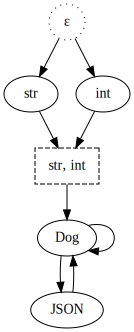

In [4]:
from monkeys.display import type_graph

type_graph()

We might also want to add some additional interactions - e.g. allowing conversions from strings to integers (and vice-versa), or allowing use of JSON as a string - but for now, let's check that what we already have works. As we can see from the graph above, we can freely choose whether we want to generate Dog instances or JSON in order to test our system - let's choose Dog instances.

In [5]:
exception_percent = 0
for __ in xrange(100):
    try:
        build_tree(Dog).evaluate()
    except Exception:
        exception_percent += 1 / 100.0
        
round(exception_percent, 2)

0.7

Oh my - about two thirds of the time, something goes wrong! Let's have `monkeys` diagnose under what circumstances we're seeing exceptions thrown.

In [6]:
# TODO - diagnostics

Now that we have identified and resolved that problem, let's allow the use of JSON as a string, revisualize our interactions, and see whether this leads to any additional bugs.

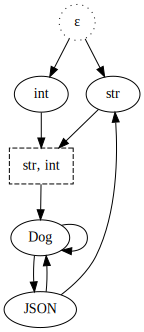

In [7]:
@params('JSON')
@rtype(str)
def json_to_str(json):
    return json  # We're already representing JSON as a string

type_graph()